# Trail Course Clustering and Recommendation

# 1.データ前処理

In [710]:
%matplotlib inline
from __future__ import print_function

import pandas as pd
import numpy as np
import os
import re
import math
import time
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import scipy.spatial as sp

## GPXファイルのデータを加工用に抽出する
#### 各コースの全ポイントの緯度、経度、標高を取得する

In [116]:
#ファイル名一覧を取得
files = os.listdir('./data')
del files[0]
len(files)

277

In [ ]:
###正規表現を使用しないVer.

cols = ['courseID','point_no','lat','lon','ele','s_g']
all_data = pd.DataFrame(columns=cols)

start = time.time()
for filename in files:

    courseID = filename[9:16]
    point_no_count = 0
    get_ele = 0
    with open ("./data/"+filename, 'r') as f:
        for line in f:
            line_s = line.strip()
            #1行にlat,lon,eleが入っているパターンの場合
            start_line_s = '<trkpt' in line_s
            end_line_s = '</trkpt>' in line_s
            if start_line_s and end_line_s:
                sp = line_s.split('"')
                lat = sp[1]
                lon = sp[3]
                ele = sp[4].split('<ele>')[1].split('</ele>')[0]
                list_data = [courseID, point_no_count, lat, lon, ele]
                if point_no_count == 0:
                    list_data.append('s')
                    series = pd.Series(list_data, cols)
                    all_data = all_data.append(series, ignore_index=True)
                    point_no_count += 1
                else:
                    list_data.append('')
                    series = pd.Series(list_data, cols)
                    all_data = all_data.append(series, ignore_index=True)
                    point_no_count += 1

            #lat,lonとeleが2行で入っているパターンの場合
            elif start_line_s and not end_line_s:
                sp = line_s.split('"')
                lat = sp[1]
                lon = sp[3]
                list_data = [courseID,point_no_count,lat,lon] 
                get_ele = 1

            elif get_ele == 1 and '<ele>' in line_s:
                ele = line_s.split('<ele>')[1].split('</ele>')[0]
                if courseID == list_data[0] and point_no_count == list_data[1]:
                    list_data.append(ele)
                    if  point_no_count == 0:
                        #コースの最初のデータにstartフラグ
                        list_data.append('s')
                    else:
                        list_data.append('')
                    list_series = pd.Series(list_data, cols)
                    all_data = all_data.append(list_series, ignore_index=True)
                    point_no_count += 1
                    get_ele = 0

            #コースの最後のデータにGoalフラグ
            #elif '</trkseg>' in line_s:
             #       all_data.at[all_data.shape[0]-1,'s_g'] = 'g'
              #      break

print(all_data.tail())
elapsed_time = time.time() - start
print("elapsed_time:{0}".format(elapsed_time) + "[sec]")

## 抽出後のデータ加工

In [154]:
#ファイル名一覧を取得
files = os.listdir('./result')
del files[0]
files

['no_1_20.csv',
 'no_2_20.csv',
 'no_3_20.csv',
 'no_4_20.csv',
 'no_5_20.csv',
 'no_6_20.csv',
 'no_7_30.csv']

In [164]:
#データ読み込み
data = pd.DataFrame()
data_2 = pd.DataFrame()

counter = 0
for filename in files:
    if counter == 0:
        data = pd.read_csv("./result/"+filename)
        print(filename,data.shape)
    else:
        data_2 = pd.read_csv("./result/"+filename)
        print(filename,data_2.shape)
        data = data.append(data_2,ignore_index=True)
    counter += 1

print(data.shape)       
data.head()

no_1_20.csv (94514, 7)
no_2_20.csv (63350, 7)
no_3_20.csv (85811, 7)
no_4_20.csv (43280, 7)
no_5_20.csv (66400, 7)
no_6_20.csv (56041, 7)
no_7_30.csv (63622, 7)
(473018, 7)


,Unnamed: 0,courseID,point_no,lat,lon,ele,s_g
0,0,1263822,0,35.726755,138.728100,489.986908,s
1,1,1263822,1,35.726614,138.727985,522.048218,NaN
2,2,1263822,2,35.726910,138.728001,516.375732,NaN
3,3,1263822,3,35.726954,138.727524,531.109802,NaN
4,4,1263822,4,35.727124,138.728141,528.785156,NaN


In [165]:
data.tail()

,Unnamed: 0,courseID,point_no,lat,lon,ele,s_g
473013,63617,1325590,1160,35.041807,140.020751,-1.0,NaN
473014,63618,1325590,1161,35.041738,140.020679,-1.0,NaN
473015,63619,1325590,1162,35.041663,140.020574,0.0,NaN
473016,63620,1325590,1163,35.041741,140.020499,0.0,NaN
473017,63621,1325590,1164,35.041710,140.020394,0.0,NaN


### コース毎に集計する
#### 全長距離、累積標高、平均緯度経度などを集計する

In [68]:
#緯度経度から2地点間の距離を計算する関数

##ヒュベニの距離計算式（旧日本測地系）
# D=sqrt((M*dP)*(M*dP)+(N*cos(P)*dR)*(N*cos(P)*dR))  
#           D:  ２点間の距離(m) 
#           P:  ２点の平均緯度 
#           dP: ２点の緯度差 
#           dR: ２点の経度差 
#           M:  子午線曲率半径 M=6334834/sqrt((1-0.006674*sin(P)*sin(P))^3)
#           N:  卯酉線曲率半径 N=6377397/sqrt(1-0.006674*sin(P)*sin(P))

def deg2rad(deg):
    return ( deg * (2 * math.pi) / 360 )

#世界測地系で計算
def calc_hubeny_dist_2(lat1, lon1, lat2, lon2):
    a = 6378137.000
    b = 6356752.314140
    e = math.sqrt( (a**2 - b**2) / a**2 )
    e2 = e**2
    mnum = a * (1 - e2)

    my = deg2rad((lat1+lat2) /2.0)
    dy = deg2rad(lat1-lat2)
    dx = deg2rad(lon1-lon2)
    sin = math.sin(my)
    w = math.sqrt(1.0-e2 * sin *sin)
    m = mnum /(w *w *w)
    n = a/w
    dym = dy*m
    dxncos = dx*n*math.cos(my)
    return ( math.sqrt( dym**2 + dxncos**2) )

In [162]:
#存在するコースIDリストを取得
courseIDs = data['courseID'].value_counts().index
len(courseIDs)

150

In [182]:
#集計できないデータを除く
drop_courseID = 1323349

In [184]:
#コースID毎にデータを取得して計算
cols = ['courseID','total_distance','total_ascent','total_descent','s_lat','s_lon','g_lat','g_lon','mean_lat','mean_lon','mean_ele','median_ele','max_ele','min_ele','mean_slope','median_slope','max_slope']
course_data = pd.DataFrame(columns=cols)
data_ID = pd.DataFrame()

#counter_test = 0
start = time.time()
for ID in courseIDs:
    if ID == drop_courseID:
        continue
    
    #該当コースのデータのみ取得
    data_ID = data[data['courseID'].isin([ID])] 
    data_ID.sort_values(by='point_no')

    counter = 0
    total_distance = 0
    total_ascent = 0
    total_descent = 0
    sum_dif_ele = 0
    sum_dif_dist = 0
    list_slope = []
    for i,v in data_ID.iterrows():
        if counter == 0:
            latA = v['lat']
            lonA = v['lon']
            eleA = v['ele']
            s_lat = latA
            s_lon = lonA
            data_means = data_ID[['lat','lon','ele']].mean()
            mean_lat = data_means['lat']
            mean_lon = data_means['lon']
            mean_ele = data_means['ele']
            median_ele = np.median(data_ID['ele'])
            max_ele = np.max(data_ID['ele'])
            min_ele = np.min(data_ID['ele'])
            ele_100_s = eleA
        else:
            latB = latA #前地点のデータ
            lonB = lonA
            eleB = eleA
            latA = v['lat'] #今の地点のデータ
            lonA = v['lon']
            eleA = v['ele']
            #2地点間の距離を算出し足し上げていく
            distAB = calc_hubeny_dist_2(latA,lonA,latB,lonB)
            total_distance += distAB
            #標高の累積計算 ※距離100m以上毎に地点間の標高の差分を取得し、足しあげる
            sum_dif_dist += distAB
            if sum_dif_dist >= 100:
                dif_ele = eleA - ele_100_s
                if dif_ele > 0:
                    total_ascent += dif_ele
                    slope_100m = dif_ele/sum_dif_dist
                    list_slope.append(slope_100m)
                else:
                    total_descent += dif_ele
                sum_dif_dist = 0
                ele_100_s = eleA

        g_lat = latA
        g_lon = lonA
        counter += 1

    #slopeの集計
    mean_slope = np.mean(list_slope)
    median_slope = np.median(list_slope)
    max_slope = np.max(list_slope)
    #コース集計データを格納
    data_series = pd.Series([ID,total_distance,total_ascent,total_descent,s_lat,s_lon,g_lat,g_lon,mean_lat,mean_lon,mean_ele,median_ele,max_ele,min_ele,mean_slope,median_slope,max_slope],cols)
    course_data = course_data.append(data_series, ignore_index=True)

course_data['total_distance'] = course_data['total_distance'] * 0.001 #kmに修正
course_data['dif_ele'] = course_data['max_ele'] - course_data['min_ele']
e_time = time.time() - start
print("TIME:{}".format(e_time))

TIME:94.32499504089355


In [185]:
course_data.head()

,courseID,total_distance,total_ascent,total_descent,s_lat,s_lon,g_lat,g_lon,mean_lat,mean_lon,mean_ele,median_ele,max_ele,min_ele,mean_slope,median_slope,max_slope,dif_ele
0,1319585.0,77.395550,3321.000000,-2478.000000,35.989393,139.084015,35.858887,138.756428,35.885804,138.907011,1416.284007,1727.0,2126.0,241.0,0.089096,0.049817,1.384947,1885.0
1,1316176.0,42.147563,1290.000000,-1284.000000,36.697167,140.420947,36.728132,140.623780,36.731533,140.491881,431.094068,445.0,630.0,204.0,0.071121,0.049968,0.497752,426.0
2,1315603.0,21.672005,1420.500000,-1415.700000,35.292779,136.009999,35.219920,135.944320,35.270518,135.951014,606.414005,628.8,1028.5,84.0,0.139691,0.126068,0.441447,944.5
3,1316051.0,20.165030,1015.000000,-1017.000000,36.795665,140.169275,36.795749,140.170446,36.807148,140.171439,264.139977,263.0,401.0,163.0,0.099613,0.069653,0.398062,238.0
4,1322495.0,32.296358,2015.885814,-2030.859725,36.755703,139.599615,36.754209,139.600493,36.788968,139.598963,1045.027734,1015.0,1691.0,626.0,0.147225,0.126558,0.462146,1065.0


In [186]:
course_data.shape

(149, 18)

# 2.名寄せ（コース定義）

### 名寄せ条件(AND)
#### ①スタート地点とゴール地点の緯度経度がほぼ同一
半径500m以内前後の誤差
#### ②コース全長の距離がほぼ同一
2km以内の誤差(GPSのズレがあるため、多めに許容)
#### ③最高標高がほぼ同一
100m以内の誤差（GPSの精度の問題があるため、多めに許容）

In [ ]:
#許容する誤差
err_lat = 0.005 #約500mの緯度
err_lon = 0.006 #約500mの経度
err_TDist = 2
err_MaxEle = 100

dif_DF = pd.DataFrame()
course_data_c = course_data.copy()
course_num_list = []

for i in range(course_data.shape[0]):
    courseID = course_data['courseID'][i]

    s_lat_a = course_data.iloc[i]['s_lat']
    s_lon_a = course_data.iloc[i]['s_lon']
    g_lat_a = course_data.iloc[i]['g_lat']
    g_lon_a = course_data.iloc[i]['g_lon']
    total_distance_a = course_data.iloc[i]['total_distance']
    max_ele_a = course_data.iloc[i]['max_ele']

    dif_DF = course_data[['courseID']]
    s_lat_diff = course_data['s_lat'] - s_lat_a
    dif_DF['s_lat'] = s_lat_diff
    s_lon_diff = course_data['s_lon'] - s_lon_a
    dif_DF['s_lon'] = s_lon_diff
    g_lat_diff = course_data['g_lat'] - g_lat_a
    dif_DF['g_lat'] = g_lat_diff
    g_lon_diff = course_data['g_lon'] - g_lon_a
    dif_DF['g_lon'] = g_lon_diff
    total_dist_diff = course_data['total_distance'] - total_distance_a
    dif_DF['total_distance'] = total_dist_diff
    max_ele_diff = course_data['max_ele'] - max_ele_a
    dif_DF['max_ele'] = max_ele_diff

    same_course = dif_DF[(abs(dif_DF.s_lat) < err_lat) &\
                         (abs(dif_DF.s_lon) < err_lon) &\
                         (abs(dif_DF.g_lat) < err_lat) &\
                         (abs(dif_DF.g_lon) < err_lon) &\
                         (abs(dif_DF.total_distance) < err_TDist) &\
                         (abs(dif_DF.max_ele) < err_MaxEle)].courseID
    
    if (len(same_course) > 1) and (same_course.index[0] == course_data.index[i]):
        print(course_data.index[i],courseID,same_course.index)
        course_data_c = course_data_c.drop(same_course.index)
    else:
        continue

In [828]:
#Runtasticの2データを削除(データ形式が異なるため)
course_data_c.drop(course_data_c.index[course_data_c.courseID == 1322790], inplace=True)
course_data_c.drop(course_data_c.index[course_data_c.courseID == 1323691], inplace=True)

In [829]:
course_data_c.shape

(140, 18)

In [834]:
course_data_c.tail()

,index,courseID,total_distance,total_ascent,total_descent,s_lat,s_lon,g_lat,g_lon,mean_lat,mean_lon,mean_ele,median_ele,max_ele,min_ele,mean_slope,median_slope,max_slope,dif_ele
135,144,1315143.0,11.081590,388.000000,-387.000000,35.858957,139.310600,35.858947,139.310725,35.865880,139.308212,174.274419,175.000000,248.000000,116.000000,0.080807,0.072373,0.257975,132.000000
136,145,1324456.0,8.760134,503.980679,-488.369473,35.177460,137.176986,35.177505,137.176960,35.193879,137.170909,426.325808,462.890804,633.287315,155.773006,0.116451,0.096924,0.320799,477.514309
137,146,1322564.0,13.703593,960.000000,-959.000000,36.478827,138.945508,36.478914,138.945401,36.485311,138.920258,985.798701,1021.500000,1310.000000,604.000000,0.192065,0.133660,0.706266,706.000000
138,147,1319339.0,11.868509,1096.000000,-740.000000,34.736474,135.300686,34.796343,135.247192,34.765460,135.273023,512.700000,516.500000,917.000000,31.000000,0.147210,0.118980,0.412176,886.000000
139,148,1322665.0,8.359081,364.000000,-346.000000,34.775516,135.684586,34.802274,135.697932,34.787213,135.707446,225.888889,261.000000,331.000000,35.000000,0.076175,0.062142,0.237785,296.000000


In [833]:
course_data_c = course_data_c.reset_index()

# 3.クラスタリング

### 相関行列を確認

In [839]:
course_data_c_ = course_data_c.drop(['index','courseID','s_lat','s_lon','g_lat','g_lon','mean_lat','mean_lon','min_ele'],axis=1)
course_data_c_.shape

(140, 10)

In [840]:
correlation_matrix = np.corrcoef(course_data_c_.transpose())

In [841]:
correlation_matrix.shape

(10, 10)

In [842]:
course_data_c_.columns

Index(['total_distance', 'total_ascent', 'total_descent', 'mean_ele',
       'median_ele', 'max_ele', 'mean_slope', 'median_slope', 'max_slope',
       'dif_ele'],
      dtype='object')

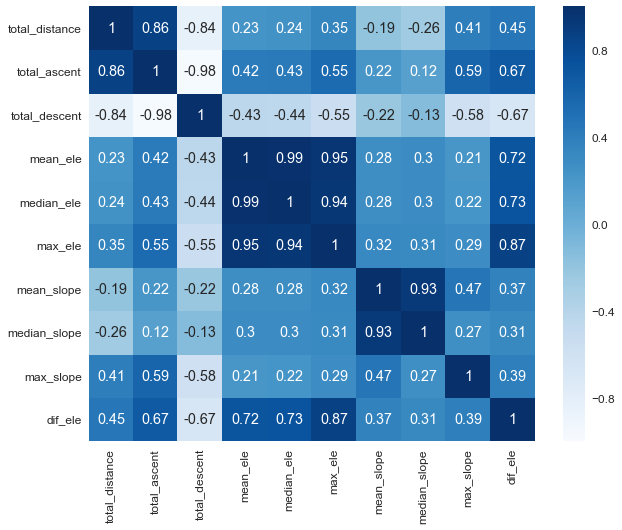

In [843]:
feature_names = ['total_distance', 'total_ascent', 'total_descent', 'mean_ele',
       'median_ele', 'max_ele', 'mean_slope', 'median_slope', 'max_slope',
       'dif_ele']
plt.subplots(figsize=(10,8))
sns.set(font_scale=1.2)
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', xticklabels=feature_names, yticklabels=feature_names)
plt.show()

### Rにて主成分分析を行い、次元圧縮

In [844]:
#特徴量作成した後のデータをcsvに書き出し、Rで主成分分析
course_data_c_.to_csv('course_data_c_.csv')

In [846]:
#Rで分析し第1主成分と第2主成分を追加したデータを読み込む
data_rpca = pd.read_csv('course_data_c_PCA.csv')

In [847]:
course_data_c['PC1'] = data_rpca['PC1'] #第一主成分
course_data_c['PC2'] = data_rpca['PC2'] #第二主成分
course_data_c.tail(10)

,index,courseID,total_distance,total_ascent,total_descent,s_lat,s_lon,g_lat,g_lon,mean_lat,...,mean_ele,median_ele,max_ele,min_ele,mean_slope,median_slope,max_slope,dif_ele,PC1,PC2
130,139,1325278.0,23.834377,1354.000000,-1354.000000,34.725657,134.105988,34.726045,134.105730,34.757561,...,262.916981,291.000000,500.000000,9.000000,0.112518,0.079651,0.497692,491.000000,1.481146,0.910165
131,140,1322621.0,17.612851,1388.649900,-1383.755796,36.534679,138.136871,36.529232,138.158875,36.505712,...,884.729776,946.839722,1272.622070,358.152100,0.180104,0.178608,0.500401,914.469970,-1.290093,-1.835284
132,141,1310486.0,19.645240,1416.986706,-1528.266009,35.404679,139.168731,35.381762,139.187586,35.430510,...,905.652090,939.682790,1493.579302,182.582714,0.178145,0.158451,0.529993,1310.996589,-1.909238,-1.556970
133,142,1320748.0,17.463096,703.000000,-784.000000,35.124944,135.644087,35.198958,135.632420,35.162485,...,426.746667,440.000000,687.000000,244.000000,0.075704,0.046377,0.433116,443.000000,1.987114,0.860191
134,143,1319857.0,4.418527,590.000000,-622.000000,34.519882,135.688825,34.520332,135.690364,34.522400,...,350.209821,354.000000,534.000000,137.000000,0.323007,0.210421,1.464619,397.000000,0.213948,-3.618889
135,144,1315143.0,11.081590,388.000000,-387.000000,35.858957,139.310600,35.858947,139.310725,35.865880,...,174.274419,175.000000,248.000000,116.000000,0.080807,0.072373,0.257975,132.000000,3.525910,0.413034
136,145,1324456.0,8.760134,503.980679,-488.369473,35.177460,137.176986,35.177505,137.176960,35.193879,...,426.325808,462.890804,633.287315,155.773006,0.116451,0.096924,0.320799,477.514309,2.052293,-0.568131
137,146,1322564.0,13.703593,960.000000,-959.000000,36.478827,138.945508,36.478914,138.945401,36.485311,...,985.798701,1021.500000,1310.000000,604.000000,0.192065,0.133660,0.706266,706.000000,-0.934780,-1.874502
138,147,1319339.0,11.868509,1096.000000,-740.000000,34.736474,135.300686,34.796343,135.247192,34.765460,...,512.700000,516.500000,917.000000,31.000000,0.147210,0.118980,0.412176,886.000000,0.642391,-0.898251
139,148,1322665.0,8.359081,364.000000,-346.000000,34.775516,135.684586,34.802274,135.697932,34.787213,...,225.888889,261.000000,331.000000,35.000000,0.076175,0.062142,0.237785,296.000000,3.314847,0.366917


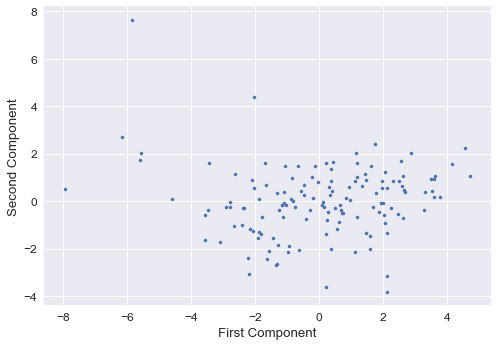

In [848]:
x = course_data_c['PC1']
y = course_data_c['PC2']
plt.scatter(x, y, s=10)
plt.xlabel("First Component")
plt.ylabel("Second Component")

### Elbow MethodでK-meansの最適なクラスター数を決める

In [849]:
data_dr_arr = np.array([x, y])

data_dr_arr = data_dr_arr.T

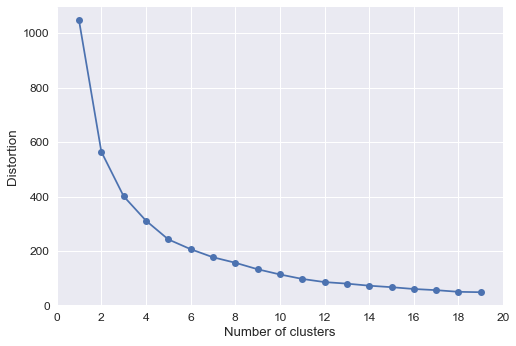

In [850]:
#1〜20クラスタの範囲で探す
distortions = []
for i in range(1,20):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data_dr_arr)
    distortions.append(kmeans.inertia_)


plt.plot(range(1,20),distortions,marker='o')
xlocs = [0,2,4,6,8,10,12,14,16,18,20]
xlabels = [0,2,4,6,8,10,12,14,16,18,20]
plt.xticks(xlocs,xlabels)
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [859]:
#クラスター数Xで分類
kmeans = KMeans(n_clusters=6)
pred = kmeans.fit_predict(data_dr_arr)

In [860]:
#クラスタ毎のコース数分布を確認
course_data_c['cluster'] = pred
course_data_c['cluster'].value_counts()

0    42
2    33
5    23
4    20
3    16
1     6
Name: cluster, dtype: int64

In [861]:
#クラスター番号を追加したデータをCSVに書き出し
course_data_c.to_csv('res_course_data_r_1220_6c.csv')

## 4.レコメンデーション
協調フィルタリングで似たコースを特定し、更に少しレベルが上がるコースを選定してレコメンドする。

### 類似度計算

In [900]:
#クラスタリング済みデータを読み込み
course_data_cluster = pd.read_csv('res_course_data_r_1220.csv')
course_data_cluster.tail()

,Unnamed: 0,index,courseID,total_distance,total_ascent,total_descent,s_lat,s_lon,g_lat,g_lon,...,median_ele,max_ele,min_ele,mean_slope,median_slope,max_slope,dif_ele,PC1,PC2,cluster
135,135,144,1315143.0,11.081590,388.000000,-387.000000,35.858957,139.310600,35.858947,139.310725,...,175.000000,248.000000,116.000000,0.080807,0.072373,0.257975,132.000000,3.525910,0.413034,0
136,136,145,1324456.0,8.760134,503.980679,-488.369473,35.177460,137.176986,35.177505,137.176960,...,462.890804,633.287315,155.773006,0.116451,0.096924,0.320799,477.514309,2.052293,-0.568131,3
137,137,146,1322564.0,13.703593,960.000000,-959.000000,36.478827,138.945508,36.478914,138.945401,...,1021.500000,1310.000000,604.000000,0.192065,0.133660,0.706266,706.000000,-0.934780,-1.874502,4
138,138,147,1319339.0,11.868509,1096.000000,-740.000000,34.736474,135.300686,34.796343,135.247192,...,516.500000,917.000000,31.000000,0.147210,0.118980,0.412176,886.000000,0.642391,-0.898251,3
139,139,148,1322665.0,8.359081,364.000000,-346.000000,34.775516,135.684586,34.802274,135.697932,...,261.000000,331.000000,35.000000,0.076175,0.062142,0.237785,296.000000,3.314847,0.366917,0


In [901]:
course_data_c = course_data_cluster.reset_index()
course_data_cluster.drop(['index'],axis=1,inplace=True)

In [902]:
course_data_cluster.tail()

,Unnamed: 0,courseID,total_distance,total_ascent,total_descent,s_lat,s_lon,g_lat,g_lon,mean_lat,...,median_ele,max_ele,min_ele,mean_slope,median_slope,max_slope,dif_ele,PC1,PC2,cluster
135,135,1315143.0,11.081590,388.000000,-387.000000,35.858957,139.310600,35.858947,139.310725,35.865880,...,175.000000,248.000000,116.000000,0.080807,0.072373,0.257975,132.000000,3.525910,0.413034,0
136,136,1324456.0,8.760134,503.980679,-488.369473,35.177460,137.176986,35.177505,137.176960,35.193879,...,462.890804,633.287315,155.773006,0.116451,0.096924,0.320799,477.514309,2.052293,-0.568131,3
137,137,1322564.0,13.703593,960.000000,-959.000000,36.478827,138.945508,36.478914,138.945401,36.485311,...,1021.500000,1310.000000,604.000000,0.192065,0.133660,0.706266,706.000000,-0.934780,-1.874502,4
138,138,1319339.0,11.868509,1096.000000,-740.000000,34.736474,135.300686,34.796343,135.247192,34.765460,...,516.500000,917.000000,31.000000,0.147210,0.118980,0.412176,886.000000,0.642391,-0.898251,3
139,139,1322665.0,8.359081,364.000000,-346.000000,34.775516,135.684586,34.802274,135.697932,34.787213,...,261.000000,331.000000,35.000000,0.076175,0.062142,0.237785,296.000000,3.314847,0.366917,0


In [923]:
#類似度を計算する関数
#コースIDを渡すと1コースレコメンドされる

def calc_similarity(target_ID,dataset):
    #類似度計算には次元圧縮したPC1,PC2を利用する
    pcdata_arr = np.array(dataset[['PC1','PC2']])

    #ターゲットのコースIDのindexを取得
    target_index = list(dataset['courseID']).index(target_ID)

    #ターゲットとそれ以外のコースの類似度を計算
    similarity = []
    for i in range(len(pcdata_arr)):
        sim = 1 - sp.distance.cosine(pcdata_arr[target_index], pcdata_arr[i])
        similarity.append(sim)

    arg_sort = np.argsort(similarity)
    arg_sort = arg_sort[::-1] #indexを返す

    return arg_sort,target_index,similarity

#### 類似度の高いコースから
#### ①場所が近すぎるコースは排除（名寄せしきれていない可能性がある、かつ目新しいコースを紹介するため）
#### ②よりレベルアップしたコースを選定する
PC1: recommended < target  OR 　PC2 >= 0: recommended > target , PC2 < 0: recommended < target 

In [1]:
#レコメンドする関数
#コースIDとデータを渡すと1コースレコメンドされる
def get_recommended_course(target_ID, dataset):
    
    sim = calc_similarity(target_ID, dataset)
    target_index = sim[1]
    
    target_data =  dataset.iloc[target_index]
    target_mean_lat = target_data['mean_lat']
    target_mean_lon = target_data['mean_lon']
    target_PC1 = target_data['PC1']
    target_PC2 = target_data['PC2']

    arg_sort = sim[0]

    #targetのデータを表示
    print("<Input>")
    print("コースID:",target_ID,"Level:",target_data.cluster)
    print("距離:",target_data.total_distance,"累積標高:",target_data.total_ascent,"平均勾配:",target_data.mean_slope,"最高標高:",target_data.max_ele)

    c = []
    recommend_index = []
    counter = 0

    for i in arg_sort:  
        if i == target_index:
            continue

        mean_lat = dataset.iloc[i]['mean_lat']
        mean_lon = dataset.iloc[i]['mean_lon']
        dist = calc_hubeny_dist_2(mean_lat,mean_lon,target_mean_lat,target_mean_lon)

        if dist < 1000: #①約1km圏内は排除
            counter +=1
            continue
        elif not c: #よりハードなコースがない場合は類似度が最高のものを出す
            print("not c", dataset.iloc[i]['courseID'])
            c = i

        PC1 = dataset.iloc[i]['PC1']
        PC2 = dataset.iloc[i]['PC2']

        #よりハード(なはずの)コースが見つかれば抜ける
        if PC1 < target_PC1:
            recommend_index = i
            print("courseID:",dataset.iloc[i]['courseID'])
            print("PC1:",PC1,target_PC1)
            print("PC2:",PC2,target_PC2)
            break

        if target_PC2 >= 0:
            if PC2 > target_PC2:
                recommend_index = i
                print("courseID:",dataset.iloc[i]['courseID'])
                print("PC1:",PC1,target_PC1)
                print("PC2:",PC2,target_PC2)
                break
            else:
                counter +=1
                continue
        else:
            if PC2 < target_PC2:
                recommend_index = i
                print("courseID:",dataset.iloc[i]['courseID'])
                print("PC1:",PC1,target_PC1)
                print("PC2:",PC2,target_PC2)
                break
            else:
                counter +=1
                continue

        counter +=1

    if (not recommend_index) and c:
        recommend_index = c
    elif (not recommend_index) and (not c):
        print("レコメンドできるコースがありません。")

    recommend_course = dataset.iloc[recommend_index]

    print("<<おすすめのコース>>",counter)
    print("コースID:",recommend_course['courseID'],"Level:",recommend_course['cluster'])
    print("距離:",recommend_course['total_distance'],"累積標高:",recommend_course['total_ascent'],"平均勾配:",recommend_course['mean_slope'],"最高標高:",recommend_course['max_ele'])


In [928]:
get_recommended_course(1315914,course_data_cluster)

<Input>
コースID: 1315914 Level: 2.0
距離: 38.3204105727 累積標高: 1749.0 平均勾配: 0.096892336525 最高標高: 854.0
not c 1314822.0
courseID: 1314822.0
PC1: 0.382530558116 0.442617767865
PC2: 1.37470768101 1.67091291293
<<おすすめのコース>> 0
コースID: 1314822.0 Level: 2.0
距離: 34.3131073942 累積標高: 1947.0 平均勾配: 0.11676012838 最高標高: 662.0
